In [ ]:
import pandas as pd

import re
import requests

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

## 1. Load the Dataset

In [ ]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/forward_firm_universe.xlsx")

df.head()

,Entity_Name,LEI,ISIN
0,Shell PLC,21380068P1DRHMJ8KU70,BRRDSABDR009
1,A Finkl & Sons Co,NaN,NaN
2,A. Finkl & Sons Corp,NaN,NaN
3,AEP Generating Co,NaN,NaN
4,AGL Loy Yang Pty Ltd,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23446 entries, 0 to 23445
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Entity_Name  23446 non-null  object
 1   LEI          1 non-null      object
 2   ISIN         6 non-null      object
dtypes: object(3)
memory usage: 549.6+ KB


In [ ]:
# Lowercase strings in a cloumn
df['Entity_Name'] = df['Entity_Name'].str.lower()

In [ ]:
# slicing rows from 1 to 10000
sliced_df = df.iloc[1:10001]
sliced_df

,Entity_Name,LEI,ISIN
1,a finkl & sons co,NaN,NaN
2,a. finkl & sons corp,NaN,NaN
3,aep generating co,NaN,NaN
4,agl loy yang pty ltd,NaN,NaN
5,agl sa generation pty ltd,NaN,NaN
...,...,...,...
9996,tibet taifeng investment,NaN,NaN
9997,tibet zhicheng green energy technology,NaN,NaN
9998,tiefa coal industry group daqiang coal mine,NaN,NaN
9999,tiefeng coal industry co ltd datong coal mine ...,NaN,NaN


##2. Duplicate Identification and Cleaning

* The goal here is to identify companies with slight name variations or suffix differences (e.g., "Ltd," "PLC," "Corp").


In [ ]:
## 1. Standardize Company Names

# Sample list of suffixes to remove
suffixes = r"\b(Ltd|PLC|Corp|LLC|Inc|Limited|Co)\b"

def standardize_name(name):
    # Remove common suffixes and extra whitespace
    name = re.sub(suffixes, '',name, flags=re.IGNORECASE)

    # Remove ',' | '.' | '"'
    name = name.replace(',', '')

    name = name.replace('.', '')

    name = name.replace('"', '')

    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()
    return name

sliced_df.insert(1, 'Standardized_Name', sliced_df['Entity_Name'].apply(standardize_name))

In [ ]:
sliced_df

,Entity_Name,Standardized_Name,LEI,ISIN
1,a finkl & sons co,a finkl & sons,NaN,NaN
2,a. finkl & sons corp,a finkl & sons,NaN,NaN
3,aep generating co,aep generating,NaN,NaN
4,agl loy yang pty ltd,agl loy yang pty,NaN,NaN
5,agl sa generation pty ltd,agl sa generation pty,NaN,NaN
...,...,...,...,...
9996,tibet taifeng investment,tibet taifeng investment,NaN,NaN
9997,tibet zhicheng green energy technology,tibet zhicheng green energy technology,NaN,NaN
9998,tiefa coal industry group daqiang coal mine,tiefa coal industry group daqiang coal mine,NaN,NaN
9999,tiefeng coal industry co ltd datong coal mine ...,tiefeng coal industry datong coal mine group,NaN,NaN


In [ ]:
# Check duplicates
num_duplicates = sliced_df['Standardized_Name'].duplicated().sum()
pro_duplicates = (num_duplicates/len(sliced_df))*100


print(f"Number of duplicates: {num_duplicates}")
print(f"Proportion of duplicates: {pro_duplicates: .2f}%")

Number of duplicates: 260
Proportion of duplicates:  2.60%


In [ ]:
# Drop duplicates
sliced_df.drop_duplicates(subset=['Standardized_Name'], inplace=True)

In [ ]:
# Check the number of rows after dropping duplicates

print(f"Number of rows after dropping duplicates: {len(sliced_df)}")

Number of rows after dropping duplicates: 9740


## 3. Match Existing LEIs

In [ ]:
### Set Up the GLEIF API for Matching

# Define the GLEIF API endpoint
gleif_url = "https://api.gleif.org/api/v1/lei-records"

In [ ]:
## Define a Function to Search for LEIs by Firm Name

def get_lei_by_name(firm_name):
    params = {"filter[entity.legalName]": firm_name}
    response = requests.get(gleif_url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if data['data']:
            # Extract the LEI from the first matching result
            return data['data'][0]['id']
    return None

In [ ]:
%%time
## Apply the Function to Each Firm in the Dataset
sliced_df['LEI'] = sliced_df['Standardized_Name'].apply(get_lei_by_name)

CPU times: user 1min 19s, sys: 8.22 s, total: 1min 27s
Wall time: 57min 33s


In [ ]:
# Save filled LEI to CSV file
sliced_df.to_csv('/content/drive/MyDrive/people_data_lab/filled_LEI_10000.csv', index=False)

In [ ]:
# Check filled 'LEI' rows
print(f"Number of rows with LEI: {sliced_df['LEI'].notnull().sum()}")
sliced_df[sliced_df['LEI'].notnull()]

Number of rows with LEI: 139


,Entity_Name,Standardized_Name,LEI,ISIN
4,agl loy yang pty ltd,agl loy yang pty,5493000FMBSFUZ80YU09,NaN
6,apr energy ltd,apr energy,5493000GLL7CZRYG3481,NaN
12,abul khair ltd,abul khair,549300NCYGR1JNBTG263,NaN
13,abul khair steel ltd,abul khair steel,549300NCYGR1JNBTG263,NaN
35,alfa acciai,alfa acciai,81560000C9F091D54046,NaN
...,...,...,...,...
3069,liberty resources,liberty resources,549300P1TLWIS5HTQZ85,NaN
3070,liberty steel,liberty steel,984500F87EC8A1CBB844,NaN
3075,liepajas metalurgs as,liepajas metalurgs as,9845002K207D55EE2A72,NaN
3126,lloyds energy ltd,lloyds energy,335800T4YOINEGMM8W27,NaN


## 4. Company Enrichment API from People Data Labs


*   Entity Type
*   Industry
*   Size



In [ ]:
PDL_API_KEY = "44a6ebf1e3da0bcf7cfd9a573ed03e2e88a23c2b66e8c93d7ff67b0eb5b753e1"
pdl_cleaner_url ="https://api.peopledatalabs.com/v5/company/enrich"

def retrieve_company_info(entity_name):
    headers = {
        "Content-Type": "application/json",
        "X-Api-Key": PDL_API_KEY
    }
    params = {
        "name": entity_name,
        "pretty": True  # Optional: formats the response for easier reading
    }

    response = requests.get(pdl_cleaner_url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        # Extract the relevant fields if they exist
        name_from_pdl = data.get('name', 'Unknown')
        entity_type = data.get('type', 'Unknown')
        industry_classification = data.get('industry', 'Unknown')
        company_size = data.get('size', 'Unknown')

        return name_from_pdl, entity_type, industry_classification, company_size
    else:
        # Handle cases where the request fails
        return None, None, None, None

In [ ]:
%%time
# Apply the function to each company name and add results to new columns
sliced_df[['name_from_pdl', 'Entity Type', 'Industry Classification', 'Company Size']] = sliced_df['Standardized_Name'].apply(
    lambda name: pd.Series(retrieve_company_info(name))
)

CPU times: user 1.34 s, sys: 132 ms, total: 1.47 s
Wall time: 1min


In [ ]:
sliced_df

,Entity_Name,Standardized_Name,LEI,ISIN,name_from_pdl,Entity Type,Industry Classification,Company Size
1,a finkl & sons co,a finkl & sons,None,NaN,None,None,None,None
3,aep generating co,aep generating,None,NaN,None,None,None,None
4,agl loy yang pty ltd,agl loy yang pty,5493000FMBSFUZ80YU09,NaN,None,None,None,None
5,agl sa generation pty ltd,agl sa generation pty,None,NaN,None,None,None,None
6,apr energy ltd,apr energy,5493000GLL7CZRYG3481,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...
146,azerbaijan integrated steel mill complex,azerbaijan integrated steel mill complex,None,NaN,None,None,None,None
147,bank of jilin co ltd,bank of jilin,None,NaN,None,None,None,None
148,bce-mach,bce-mach,549300X1BQJEYK1PCP92,NaN,None,None,None,None
149,beris jiangsu heavy industry co ltd,beris jiangsu heavy industry,None,NaN,None,None,None,None


## Free Company Dataset from People Data labs

In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
import patoolib

In [ ]:
patoolib.extract_archive('/content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip')

INFO patool: Extracting /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip ...
INFO:patool:Extracting /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip ...
INFO patool: running /usr/bin/7z e -o./Unpack_lbals36y -- /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip
INFO:patool:running /usr/bin/7z e -o./Unpack_lbals36y -- /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip
INFO patool: ... /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip extracted to `free_company_dataset.csv1' (local file exists).
INFO:patool:... /content/drive/MyDrive/people_data_lab/free_company_dataset.csv.zip extracted to `free_company_dataset.csv1' (local file exists).


'free_company_dataset.csv1'

In [ ]:
company_df = pd.read_csv('/content/drive/MyDrive/free_company_dataset.csv1/free_company_dataset.csv', on_bad_lines='skip')

In [ ]:
company_df = pd.read_csv('/content/free_company_dataset.csv1/free_company_dataset.csv', on_bad_lines='skip', engine='python')

## 5.Results

In [ ]:
company_df = pd.read_csv('/content/free_company_dataset.csv1/free_company_dataset.csv', on_bad_lines='skip', engine='python')

In [ ]:

# the number and proportion of enriched LEI, Entity Type, Industry Classification, Company Size
count_lei = sliced_df['LEI'].notnull().sum()
count_type = sliced_df['Entity Type'].notnull().sum()
count_industry = sliced_df['Industry Classification'].notnull().sum()
count_size = sliced_df['Company Size'].notnull().sum()

pro_lei = (count_lei/len(sliced_df))*100
pro_type = (count_type/len(sliced_df))*100
pro_industry = (count_industry /len(sliced_df))*100
pro_size = (count_size/len(sliced_df))*100

print("============ The number of enriched rows ============")
print(f"Number of LEI: {count_lei}\n")
print(f"Number of Entity Type: {count_type}\n")
print(f"Number of Industry Classification: {count_industry}\n")
print(f"Number of Company Size: {count_size}\n")
print("============ The increase rate ===================")
print(f"\nProportion of LEI: +{pro_lei: .3f}%\n")
print(f"Proportion of Entity Type: +{pro_type: .3f}%\n")
print(f"Proportion of Industry Classification: +{pro_industry: .3f}%\n")
print(f"Proportion of Company Size: +{pro_size: .3f}%\n")

NameError: name 'sliced_df' is not defined

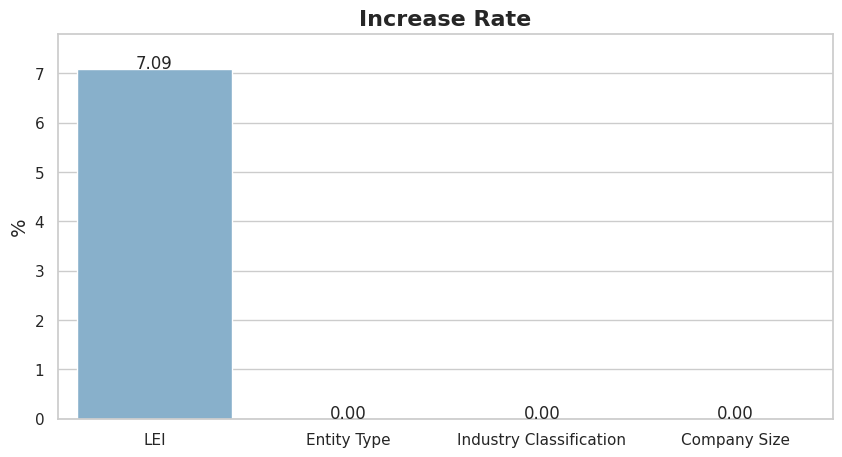

In [ ]:
# Set a theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Data for the plot
x = ['LEI', 'Entity Type', 'Industry Classification', 'Company Size']
y = [pro_lei, pro_type, pro_industry, pro_size]

# Create barplot with a color palette
sns.barplot(x=x, y=y, ax=ax, palette="Blues_d")

# Adding title and labels
ax.set_title("Increase Rate", fontsize=16, fontweight='bold')
ax.set_ylabel("%", fontsize=14)

# Displaying values on top of each bar
for index, value in enumerate(y):
    ax.text(index, value + 0.01, f"{value:.2f}", ha='center', fontsize=12)

# Adjust y-axis limit for better spacing
ax.set_ylim(0, max(y) * 1.1)

plt.show();